<a href="https://colab.research.google.com/github/miz-ab/10xac_week_two_challenge/blob/main/notebooks/Smart_Ad_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scs
import statsmodels.api as sm
import seaborn as sns
from sklearn import preprocessing 
from sklearn.preprocessing import scale
from scipy.stats import spearmanr
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn import metrics
from matplotlib import rcParams
from matplotlib.pyplot import pie, axis, show
from scipy.stats import norm
import xgboost as xgb


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
pd.set_option('max_column', None)
df= pd.read_csv('drive/MyDrive/AdSmartABdata .csv')

In [5]:
df.head(3)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1


In [6]:
#filter users who chose "yes" or "no"
responded = df[(df.yes == 1)|(df.no == 1)].reset_index()
#drop the index from the original dataset
responded.drop('index', axis=1, inplace=True)
responded.shape

(1243, 9)

In [7]:
#get unique values of each column
responded.nunique()

auction_id     1243
experiment        2
date              8
hour             24
device_make     115
platform_os       2
browser           8
yes               2
no                2
dtype: int64

In [8]:
def count_plot(variable):
    sns.countplot(x=variable, data=responded)
    
def bar_plot(variable):
    sns.barplot(y=variable, x='yes', data=responded, orient='h')

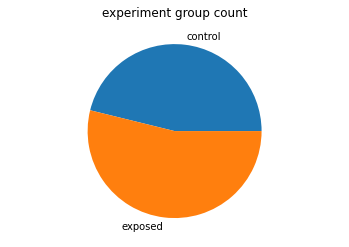

In [9]:
sums = responded["yes"].groupby(responded.experiment).sum()
plt.title("experiment group count")
axis('equal');
pie(sums, labels=sums.index);
show()

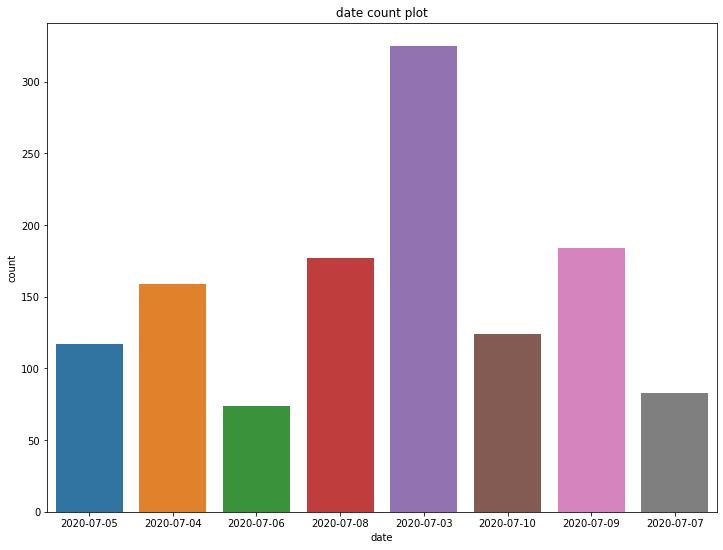

In [10]:
#plot value counts columns
plt.figure(figsize=(12,9))
plt.title("date count plot")
count_plot( "date")

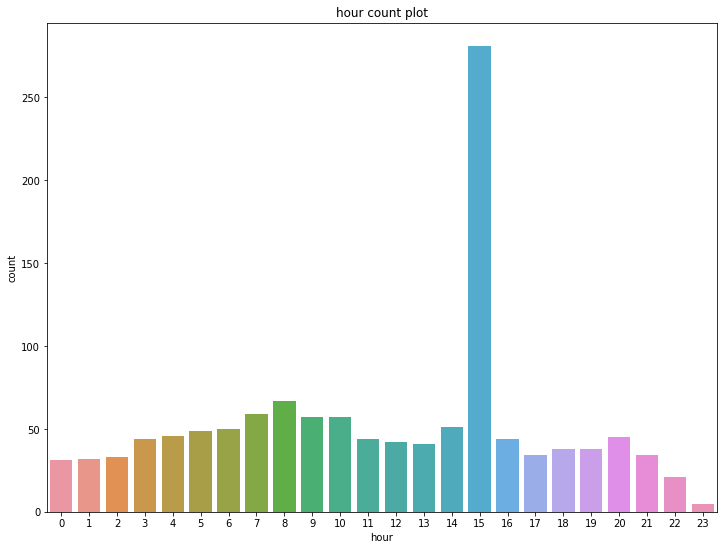

In [11]:
plt.figure(figsize=(12,9))
plt.title("hour count plot")
count_plot( "hour")

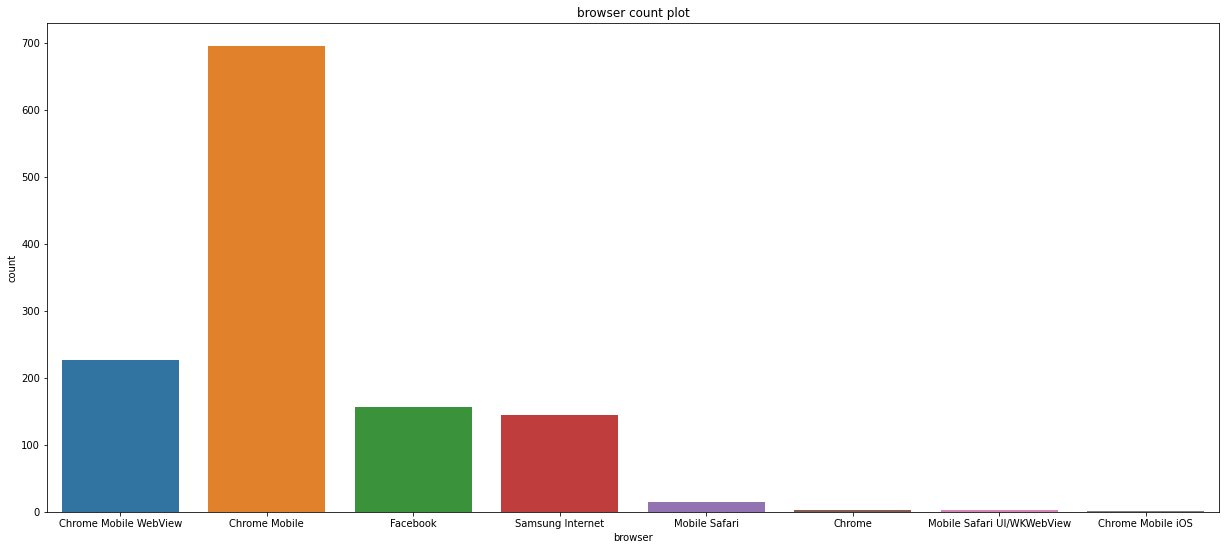

In [43]:
plt.figure(figsize=(21,9))
plt.title("browser count plot")
count_plot("browser")

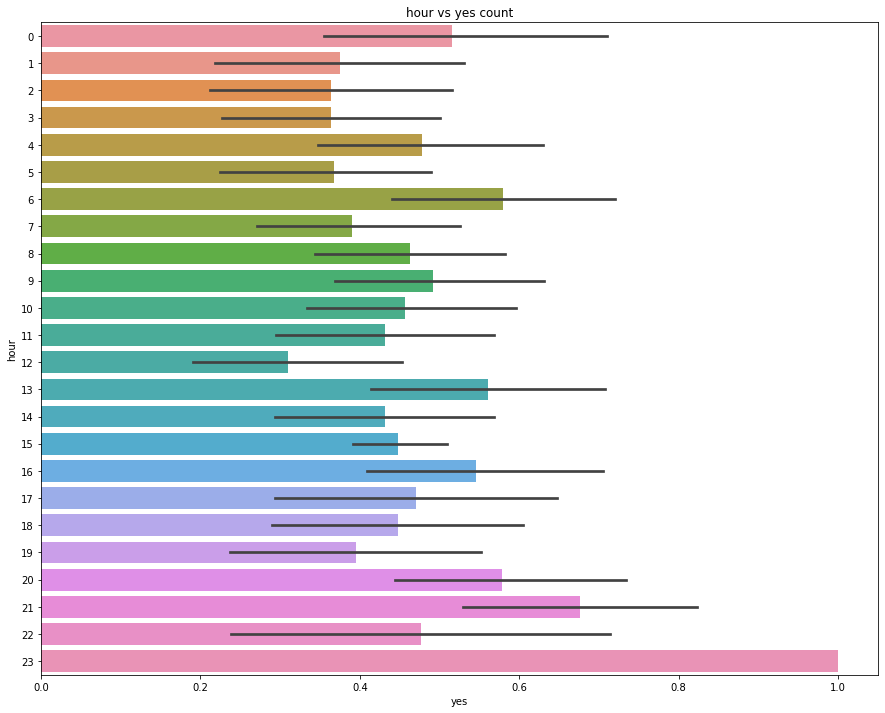

In [44]:
#The plot below shows the portion of users who said "yes" per hour. It looks users responding at 23:00 o'clock, whatever their number, said "yes"
plt.figure(figsize=(15,12))
plt.title("hour vs yes count")
bar_plot('hour')

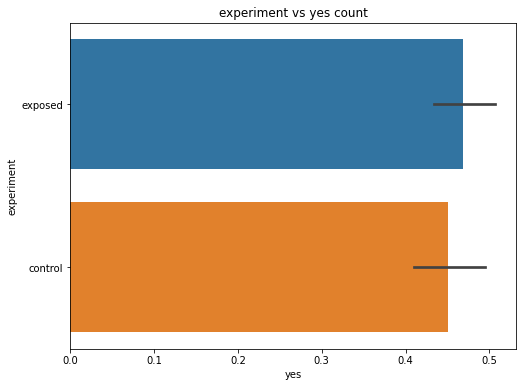

In [16]:
#In the plot below, we can see that more users in the exposed group said yes than in control group. But we need to rely on the A/B test to confirm this.
plt.figure(figsize=(8,6))
plt.title("experiment vs yes count")
bar_plot('experiment')

In [42]:
#Part 2: Classical A/B testing

#Let's carry out classical A/B testing by calculating p-vale using statistical tests

#subset of users with id and group only


In [31]:
#check if we have sufficient sample size
ml_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243 entries, 0 to 1242
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   experiment   1243 non-null   int64
 1   date         1243 non-null   int64
 2   hour         1243 non-null   int64
 3   device_make  1243 non-null   int64
 4   platform_os  1243 non-null   int64
 5   browser      1243 non-null   int64
 6   yes          1243 non-null   int64
dtypes: int64(7)
memory usage: 68.1 KB


##Classic A/B testing analysis

**Null hypothesis**: there is no significant difference in brand awareness between the exposed and control groups in the current case

**Alternate hypothesis**: there is a significant difference in brand awareness between the exposed and control groups in the current case
with an assumptiono of this two

- form the bussiness perspective lets say a 2% brand awarenes increase woul be practically significant.dmin=0.02
- and have a confidence level of 95%
Ho:d=0 d~N(0,SEpool)
If d>1.96SEpool or d<-1.96SEpool Reject the null

In [32]:
Co_df=df.query("experiment=='control'")
Co_not_ans_df = df.query("yes == 0 & no == 0")
Co_Yes_ans_df=df.query("yes == 1")
print(f"the number of users that did not respond in the control group is {Co_not_ans_df.shape[0]} ")
print(f"the number of users that did  respond yes in the Control group is {Co_Yes_ans_df.shape[0]} ")
Xcon=Co_Yes_ans_df.shape[0]
print(f"the percentage of users that did not respond in the control group is {(Co_not_ans_df.shape[0] / Co_df.shape[0]) * 100}% ")

the number of users that did not respond in the control group is 6834 
the number of users that did  respond yes in the Control group is 572 
the percentage of users that did not respond in the control group is 167.87030213706706% 


In [33]:
Ex_df=df.query("experiment=='exposed'")
EX_not_ans_df = df.query("yes == 0 & no == 0")
EX_Yes_ans_df=df.query("yes == 1")
print(f"the number of users that did not respond in the exposed group is {EX_not_ans_df.shape[0]} ")
print(f"the number of users that did  respond yes in the exposed group is {EX_Yes_ans_df.shape[0]} ")
Xexp=EX_Yes_ans_df.shape[0]
print(f"the percentage of users that did not respond in the exposed grou is {(EX_not_ans_df.shape[0] / Ex_df.shape[0]) * 100}% ")

the number of users that did not respond in the exposed group is 6834 
the number of users that did  respond yes in the exposed group is 572 
the percentage of users that did not respond in the exposed grou is 170.59410883674488% 


In [34]:
#select users who respond on controlled or exposed group 
RSAd_df = df.query("not (yes == 0 & no == 0)")
RSAd_df.shape
Npool=RSAd_df.shape[0]

In [35]:
RCo_df=df.query("experiment=='control'")
Nco=RCo_df.shape[0]
print(f"the number of users that did  respond  in the Control group is {RCo_df.shape[0]} ")

the number of users that did  respond  in the Control group is 4071 


In [36]:
REx_df=df.query("experiment=='exposed'")
Nex=REx_df.shape[0]
print(f"the number of users that did  respond  in the Exposed group is {REx_df.shape[0]} ")

the number of users that did  respond  in the Exposed group is 4006 


In [37]:
Ppool=(Xcon+Xexp)/Npool
print(Ppool)

0.9203539823008849


In [38]:
import math
#Pool standard error
SEpool=math.sqrt(Ppool*(1-Ppool)*((1/Nco)+(1/Nex)))
print(SEpool)

0.006025297548891211


In [39]:
## diference between Pexp and Pcon
d=Xexp/Nex-Xcon/Nco
print(d)

0.002279803090745852


In [40]:
#margin of error
m=1.96*SEpool
print(m)

0.011809583195826773


In [41]:
lb=d-m
ub=d+m
print(lb,ub)

-0.009529780105080921 0.014089386286572626


**From this output that we can say we dont have enough power to draw a conclusion we need more data to reach a conclusion.**